# Putting Your Forecasting Model to the Test: A Guide to Backtesting

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# Reset Matplotlib settings to default
mpl.rcParams.update({})

# plotting

sns.set_palette("colorblind")
plt.rcParams["figure.figsize"] = (20, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

## Generating data

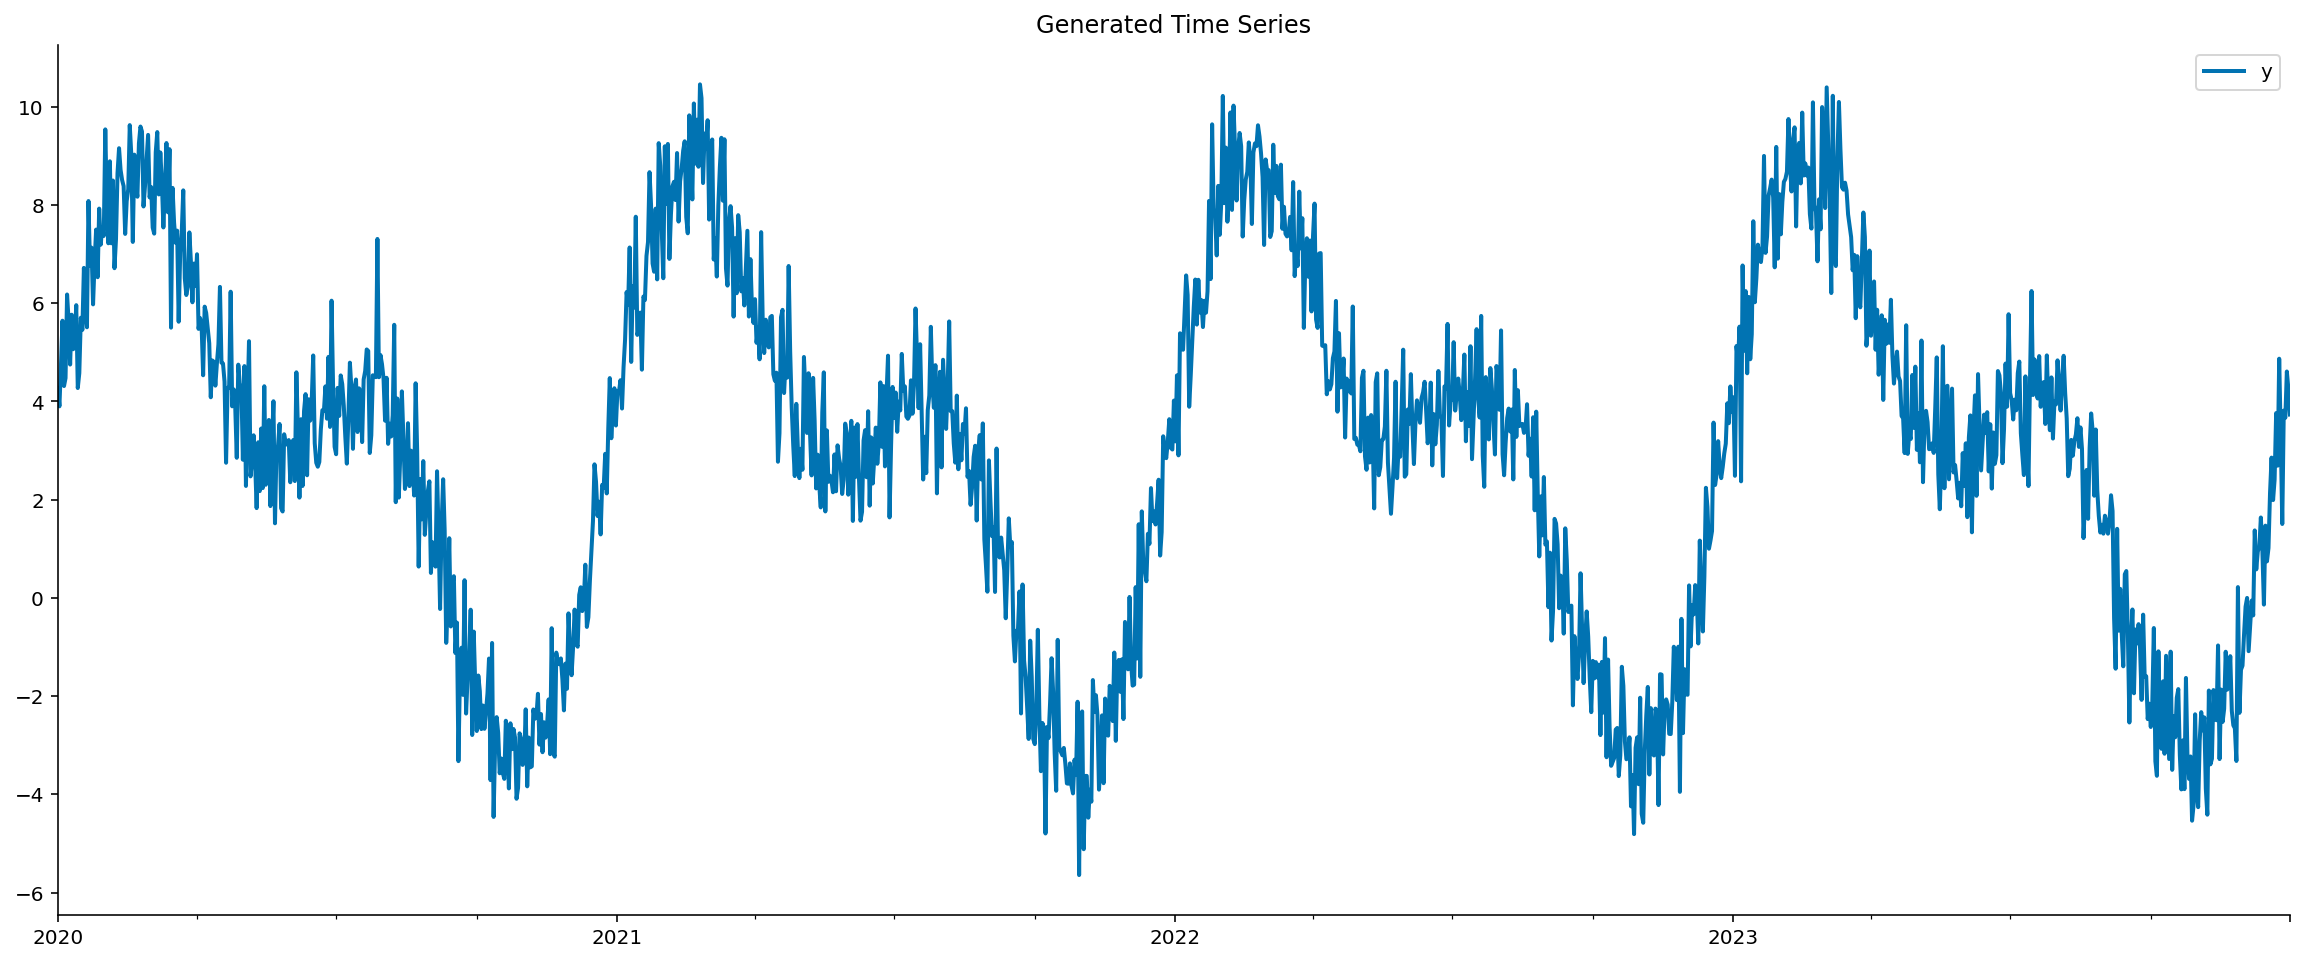

In [4]:
# Set a random seed for reproducibility
np.random.seed(42)

# Generate a DataFrame with 3 years of data
range_of_dates = pd.date_range(start="2020-01-01", end="2023-12-31")
X = pd.DataFrame(index=range_of_dates)

# Create a sequence of day numbers and add day of the year information
X["day_nr"] = range(len(X))
X["day_of_year"] = X.index.dayofyear

# Generate components of the target time series
signal_1 = 3 + 4 * np.sin(X["day_nr"] / 365 * 2 * np.pi)
signal_2 = 3 * np.sin(X["day_nr"] / 365 * 4 * np.pi + 365/2)
noise = np.random.normal(0, 0.85, len(X))

# Combine the components to get the target series
y = signal_1 + signal_2 + noise

# Convert the target series to a DataFrame and assign a column name
df = y.to_frame()
df.columns = ["y"]

# Plot the generated time series
df.plot(title="Generated Time Series");

In [5]:
dummies = pd.get_dummies(df.index.month, prefix='month', drop_first=True)
dummies.index = df.index
df = pd.concat([df, dummies], axis=1)
df

,y,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2020-01-01,4.273237,0,0,0,0,0,0,0,0,0,0,0
2020-01-02,3.900877,0,0,0,0,0,0,0,0,0,0,0
2020-01-03,4.735163,0,0,0,0,0,0,0,0,0,0,0
2020-01-04,5.644148,0,0,0,0,0,0,0,0,0,0,0
2020-01-05,4.314070,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,3.813185,0,0,0,0,0,0,0,0,0,0,1
2023-12-28,3.667402,0,0,0,0,0,0,0,0,0,0,1
2023-12-29,4.609689,0,0,0,0,0,0,0,0,0,0,1
2023-12-30,4.254854,0,0,0,0,0,0,0,0,0,0,1


## Defining the backtester class

In [6]:
class TSBacktester:
    """
    A custom time series backtester class for evaluating forecasting models.
    
    Parameters
    ----------
    pred_func : Callable
        A function that makes predictions using historical data.
    start_date : str
        The start date of the backtest period.
    end_date : str
        The end date of the backtest period.
    backtest_freq : str
        The frequency of backtest evaluations (e.g., '1D' for daily progression).
    data_freq : str
        The frequency of the data (e.g., '1D' for daily).
    forecast_horizon : int
        The number of time periods to forecast into the future.
    """

    def __init__(self, pred_func, start_date, end_date, backtest_freq, data_freq, forecast_horizon):
        self.pred_func = pred_func
        self.start_date = start_date
        self.end_date = end_date
        self.backtest_freq = backtest_freq
        self.data_freq = data_freq
        self.forecast_horizon = forecast_horizon
        self.backtest_df = None

    def run_backtest(self, df, target_col, features=None, verbose=False):
        """
        Run the time series backtest using the specified parameters.

        Parameters
        ----------
        df : pd.DataFrame
            The DataFrame containing the time series data.
        target_col : str
            The name of the target column to forecast.
        features : List[str], optional
            List of feature column names. Default is None.
        verbose : bool, optional
            If True, print information about each backtest step. Default is False.
        """

        ts_df = df.copy()

        fcst_dates = pd.date_range(self.start_date, self.end_date, freq=self.backtest_freq)
        backtest_list = []

        for forecast_date in fcst_dates:

            test_ind = pd.date_range(forecast_date, periods=self.forecast_horizon, freq=self.data_freq)

            X_train = ts_df.loc[ts_df.index < forecast_date].copy()
            y_train = X_train.pop(target_col)
            
            X_test = ts_df.loc[ts_df.index.isin(test_ind)].copy()
            y_test = X_test.pop(target_col)

            if verbose:
                print(f"Forecasting as of {forecast_date.date()} ----")
                print(f"Training data: {X_train.index.min().date()} : {X_train.index.max().date()} (n = {len(X_train)})")
                print(f"Test data: {X_test.index.min().date()} : {X_test.index.max().date()} (n = {len(X_test)})")
           
            # get predictions
            y_pred = self.pred_func(X_train, y_train, X_test, self.forecast_horizon, features)
            
            pred_df = pd.DataFrame(
                {
                    "forecast_date": forecast_date,
                    "report_date": y_test.index,
                    "forecast": y_pred,
                    "actual": y_test,
                }
            )

            backtest_list.append(pred_df)


        backtest_df = pd.concat(backtest_list, ignore_index=True)

        self.backtest_df = backtest_df

    def evaluate_backtest(self, metrics):
        """
        Evaluate the backtest using specified performance metrics.

        Parameters
        ----------
        metrics : Dict[str, Callable]
            A dictionary of metric names and their corresponding metric functions.

        Returns
        -------
        Dict[str, Dict[Union[str, int], float]]
            A dictionary containing evaluation scores for each metric.
        """

        if self.backtest_df is None:
            raise ValueError("Backtest was not yet executed! Please run it before evaluating")
        
        backtest_df = self.backtest_df.copy()

        backtest_df["horizon"] = (backtest_df["report_date"] - backtest_df["forecast_date"]).dt.days

        grouped = backtest_df.groupby('horizon')

        scores_dict = {}

        for metric, metric_func in metrics.items():
            
            scores_dict[metric] = {}
            scores_dict[metric]["total"] = metric_func(backtest_df['actual'], backtest_df['forecast'])

            for group, group_df in grouped:
                scores_dict[metric][group] = metric_func(group_df['actual'], group_df['forecast'])

        return scores_dict

## Running backtests

In [7]:
def naive_forecast(X_train, y_train, X_test, horizon, features):
    y_pred = [y_train.iloc[-1]] * horizon
    return y_pred

def mean_forecast(X_train, y_train, X_test, horizon, features):
    y_pred = [y_train.mean()] * horizon
    return y_pred

def linear_model(X_train, y_train, X_test, horizon, features):

    if features is not None:
        X_train = X_train[features]
        X_test = X_test[features]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return y_pred

def rf_model(X_train, y_train, X_test, horizon, features):

    if features is not None:
        X_train = X_train[features]
        X_test = X_test[features]
    
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return y_pred

In [8]:
# backtesting setup
BT_START_DATE = "2023-01-01"
BT_END_DATE = "2023-12-24"
BACKTEST_FREQ = "7D"
DATA_FREQ = "1D"
FCST_HORIZON = 7  

BT_METRICS = {
    "mse": mean_squared_error,
    "mae": mean_absolute_error,
}

# list of features
FEATURE_LIST = [
    "month_2", "month_3", "month_4", "month_5", "month_6", 
    "month_7", "month_8", "month_9", "month_10", "month_11", 
    "month_12"
]

scores_dict = {}

In [9]:
backtester = TSBacktester(
    naive_forecast, 
    BT_START_DATE, 
    BT_END_DATE, 
    BACKTEST_FREQ, 
    DATA_FREQ, 
    FCST_HORIZON
)

backtester.run_backtest(df, target_col="y", verbose=True)
backtest_results = backtester.evaluate_backtest(BT_METRICS)
scores_dict["naive"] = backtest_results["mae"]
pd.DataFrame(backtest_results)

Forecasting as of 2023-01-01 ----
Training data: 2020-01-01 : 2022-12-31 (n = 1096)
Test data: 2023-01-01 : 2023-01-07 (n = 7)
Forecasting as of 2023-01-08 ----
Training data: 2020-01-01 : 2023-01-07 (n = 1103)
Test data: 2023-01-08 : 2023-01-14 (n = 7)
Forecasting as of 2023-01-15 ----
Training data: 2020-01-01 : 2023-01-14 (n = 1110)
Test data: 2023-01-15 : 2023-01-21 (n = 7)
Forecasting as of 2023-01-22 ----
Training data: 2020-01-01 : 2023-01-21 (n = 1117)
Test data: 2023-01-22 : 2023-01-28 (n = 7)
Forecasting as of 2023-01-29 ----
Training data: 2020-01-01 : 2023-01-28 (n = 1124)
Test data: 2023-01-29 : 2023-02-04 (n = 7)
Forecasting as of 2023-02-05 ----
Training data: 2020-01-01 : 2023-02-04 (n = 1131)
Test data: 2023-02-05 : 2023-02-11 (n = 7)
Forecasting as of 2023-02-12 ----
Training data: 2020-01-01 : 2023-02-11 (n = 1138)
Test data: 2023-02-12 : 2023-02-18 (n = 7)
Forecasting as of 2023-02-19 ----
Training data: 2020-01-01 : 2023-02-18 (n = 1145)
Test data: 2023-02-19 : 202

,mse,mae
total,1.715974,1.079689
0,1.252658,0.889945
1,1.618429,1.038492
2,1.657908,1.068563
3,1.483663,0.993363
4,1.379052,0.983199
5,2.195328,1.260360
6,2.424781,1.323903


In [10]:
backtester = TSBacktester(
    mean_forecast, 
    BT_START_DATE, 
    BT_END_DATE, 
    BACKTEST_FREQ, 
    DATA_FREQ, 
    FCST_HORIZON
)

backtester.run_backtest(df, target_col="y")
backtest_results = backtester.evaluate_backtest(BT_METRICS)
scores_dict["mean"] = backtest_results["mae"]
pd.DataFrame(backtest_results)

,mse,mae
total,13.310294,2.904468
0,13.956943,2.954597
1,12.375865,2.819553
2,13.321713,2.896161
3,13.324800,2.838963
4,12.766704,2.847901
5,13.968202,3.041883
6,13.457832,2.932215


In [11]:
backtester = TSBacktester(
    linear_model, 
    BT_START_DATE, 
    BT_END_DATE, 
    BACKTEST_FREQ, 
    DATA_FREQ, 
    FCST_HORIZON
)

backtester.run_backtest(df, target_col="y", features=FEATURE_LIST)
backtest_results = backtester.evaluate_backtest(BT_METRICS)
scores_dict["linear"] = backtest_results["mae"]
pd.DataFrame(backtest_results)

,mse,mae
total,1.425464,0.933625
0,1.250639,0.805351
1,1.348866,0.933263
2,1.360998,0.885103
3,1.393159,0.977625
4,1.131999,0.865854
5,1.816614,1.017002
6,1.675972,1.051180


In [12]:
backtester = TSBacktester(
    rf_model, 
    BT_START_DATE, 
    BT_END_DATE, 
    BACKTEST_FREQ, 
    DATA_FREQ, 
    FCST_HORIZON
)

backtester.run_backtest(df, target_col="y", features=FEATURE_LIST)
backtest_results = backtester.evaluate_backtest(BT_METRICS)
scores_dict["rf"] = backtest_results["mae"]
pd.DataFrame(backtest_results)

,mse,mae
total,1.432477,0.935587
0,1.257607,0.807316
1,1.359006,0.936685
2,1.361460,0.885494
3,1.402805,0.980883
4,1.136442,0.867862
5,1.825078,1.017304
6,1.684939,1.053562


## Backtest results

In [13]:
mae_scores_df = pd.DataFrame(scores_dict).T
mae_scores_df

,total,0,1,2,3,4,5,6
naive,1.079689,0.889945,1.038492,1.068563,0.993363,0.983199,1.260360,1.323903
mean,2.904468,2.954597,2.819553,2.896161,2.838963,2.847901,3.041883,2.932215
linear,0.933625,0.805351,0.933263,0.885103,0.977625,0.865854,1.017002,1.051180
rf,0.935587,0.807316,0.936685,0.885494,0.980883,0.867862,1.017304,1.053562
